# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Let's generate our dataset and take a look on it.

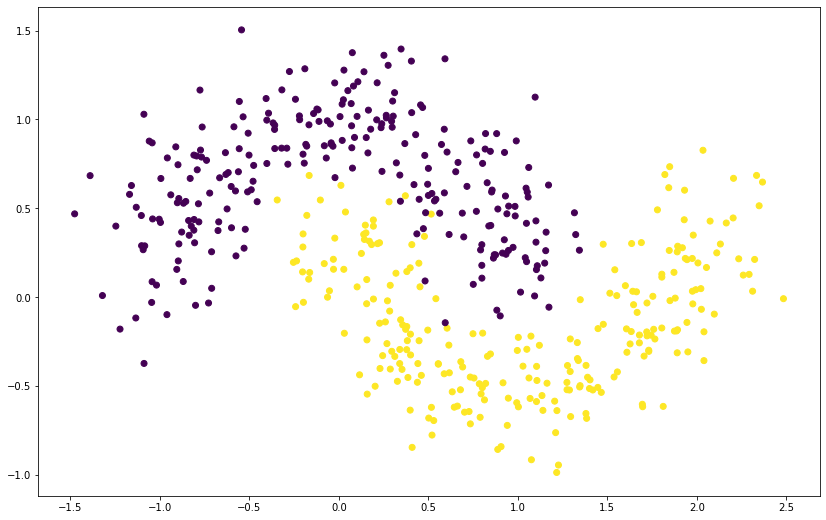

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.figure(figsize = (14, 9))
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you colud use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ wirte function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import PolynomialFeatures


# Использована комбинация функций, привёденных на семинаре, с некоторыми доработками 
def plot_decision_surface_and_function(clf, X, y, ax = None, grid_step=0.01, cmap='rainbow', alpha=0.6,
                                       space = True, poly_features = False, margin = True, color = 'k'):

    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    grid_x0, grid_x1 = np.meshgrid(
                        np.linspace(xlim[0], xlim[1], 200),
                        np.linspace(ylim[0], ylim[1], 200)
                                    )
    
    xy = np.stack([grid_x0.ravel(),grid_x1.ravel()],axis=1)
    
    
    if poly_features:
        P = clf.decision_function(poly.transform(xy)).reshape(grid_x1.shape)
        y_pred_grid = clf.predict(poly.transform(xy)).reshape(grid_x1.shape)
    else:
        P = clf.decision_function(xy).reshape(grid_x1.shape)
        y_pred_grid = clf.predict(xy).reshape(grid_x1.shape)
        
    if margin:
        ax.contour(grid_x0, grid_x1, P, colors=color,
                   levels=[-1, 0, 1], alpha=0.5,
                   linestyles=['--', '-', '--'])
    else:
        ax.contour(grid_x0, grid_x1, P, colors=color,
                   levels = 0, alpha=0.5,
                   linestyles='-')
               
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if space:
        labels = np.sort(np.unique(y))
        labels = np.concatenate([[labels[0] - 1],
                                 labels,
                                 [labels[-1] + 1]])
        medians = (labels[1:] + labels[:-1]) / 2
        plt.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                     levels=medians)

        y_pred = clf.predict(X)

        plt.scatter(*X[y_pred==y].T, c = y[y_pred==y], marker='o', cmap=cmap, s=10, label='correct')
        plt.scatter(*X[y_pred!=y].T, c = y[y_pred!=y], marker='x', cmap=cmap, s=50, label='errors')


        plt.plot([], [], ' ', label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))

        plt.legend(loc='best')

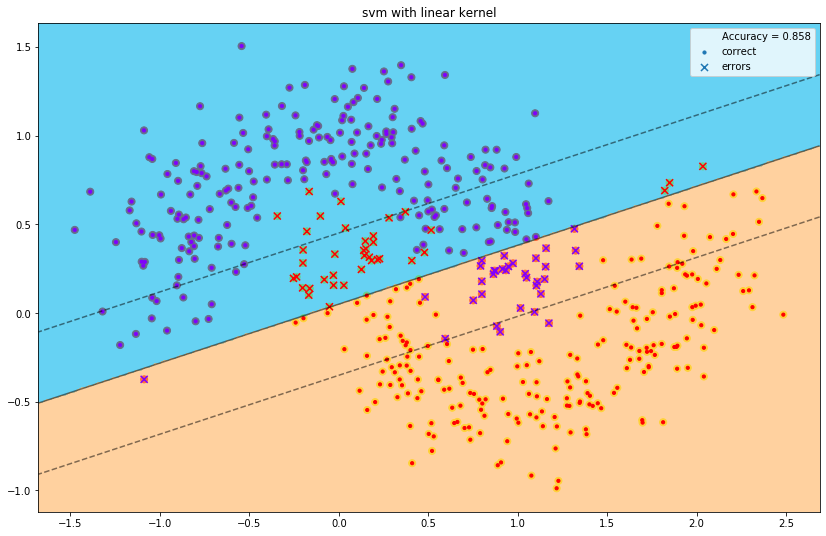

In [4]:
svm = SVC(kernel='linear')
svm.fit(moons_points, moons_labels)

plt.figure(figsize = (14, 9))
plt.title("svm with linear kernel")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, s=50, cmap='autumn')   

plot_decision_surface_and_function(svm, moons_points, moons_labels, cmap='rainbow', grid_step=0.01)

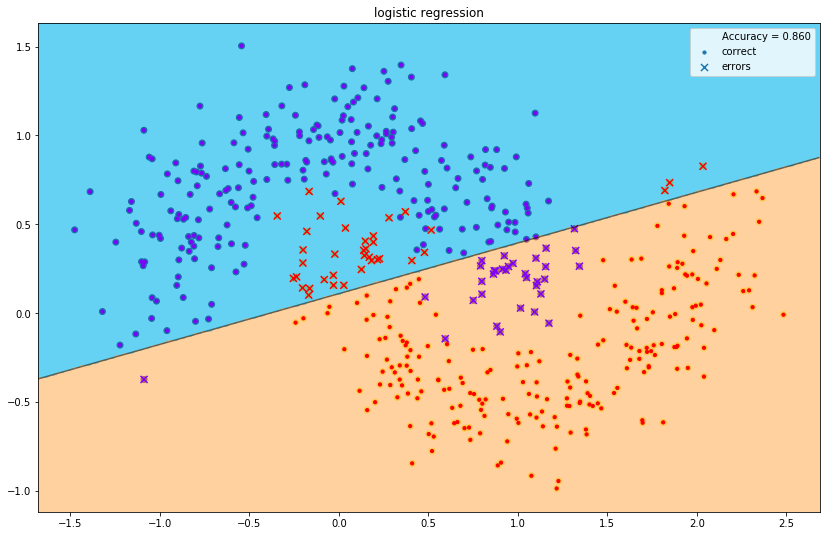

In [5]:
lr = LogisticRegression(C = 1.,
                        penalty = 'l2',
                             multi_class = 'multinomial', solver = 'saga',
                             tol = 1e-3, max_iter = 1000) 

lr.fit(moons_points, moons_labels)


plt.figure(figsize = (14, 9))
plt.title("logistic regression")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)
plot_decision_surface_and_function(lr, moons_points, moons_labels, cmap='rainbow', grid_step=0.01, margin = False)

И svm с линейным ядром (стандартный svm) и логистическая регрессия строят линейную разделяющую гиперплоскость. Так как данные в этой задаче линейно не отделимы, получаем не очень хорошую точность классификации (<0.9), но всё же приемлемую. 

## 1.2 Kernel tirck

![keep-calm](https://github.com/girafe-ai/ml-mipt/blob/basic_f20/homeworks_basic/Lab1_ML_pipeline_and_SVM/imgs/keep-calm.jpg?raw=1)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border changed for each kernel?
* What `degree` have you chosen and why?

{'coef0': 1.0000000000000027, 'degree': 13}


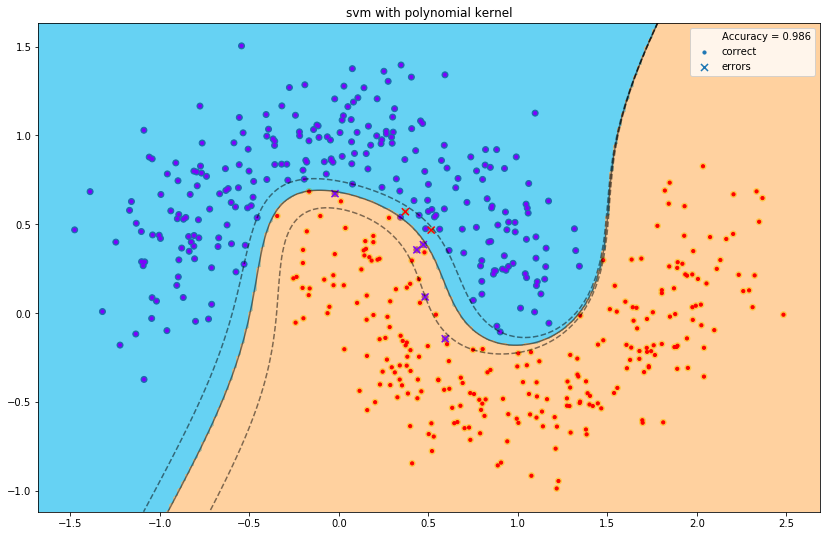

In [83]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

svm_grid_search = GridSearchCV(
                            SVC(kernel='poly'),
                            [{'degree': np.arange(1, 15), 
                            'coef0': np.arange(-2.0, 2.0, 0.1)}],
                            cv=5,
                            n_jobs=-1,
                            scoring='accuracy')


svm_grid_search.fit(moons_points, moons_labels)
print(svm_grid_search.best_params_)

svm = SVC(kernel='poly',
          degree = svm_grid_search.best_params_['degree'],
          coef0 = svm_grid_search.best_params_['coef0'])

svm.fit(moons_points, moons_labels)

plt.figure(figsize = (14, 9))
plt.title("svm with polynomial kernel")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)
plot_decision_surface_and_function(svm, moons_points, moons_labels, cmap='rainbow', grid_step=0.01)  

1) Качество классификации значительно выросло. 

2) Разделяющая граница стала сильно нелинейной - полиномом выбранной степени.

3) Оптимальная степень полинома выбиралась с помощью grigsearchCV в диапозоне от 2 до 15 и равна 13.

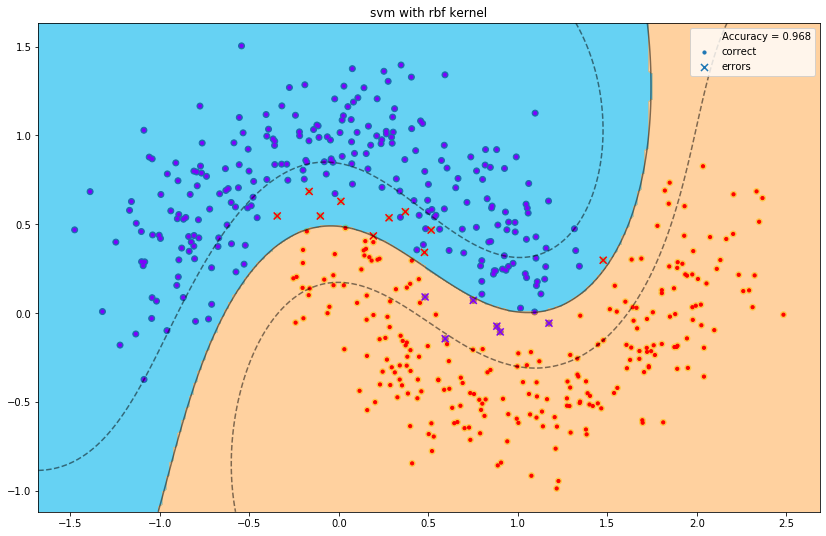

In [73]:
svm = SVC(kernel='rbf') 
svm.fit(moons_points, moons_labels)


plt.figure(figsize = (14, 9))
plt.title("svm with rbf kernel")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)
plot_decision_surface_and_function(svm, moons_points, moons_labels, cmap='rainbow', grid_step=0.01)  

1) Качество классификации значительно выросло (по сравнению с линейным ядром). 

2) Разделяющая граница стала сильно нелинейной.

{'coef0': -2.4000000000000163}


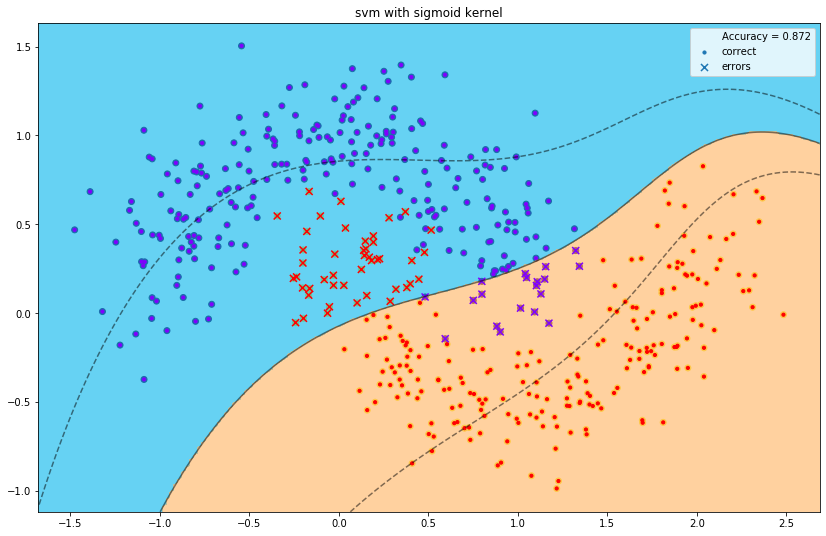

In [74]:
svm_grid_search = GridSearchCV(
                            SVC(kernel='sigmoid'),
                            [{'coef0': np.arange(-7.0, 5.0, 0.1)}],  
                            cv=5,
                            n_jobs=-1,
                            refit=True,
                            scoring='accuracy')


svm_grid_search.fit(moons_points, moons_labels)
print(svm_grid_search.best_params_)

svm = SVC(kernel='sigmoid', coef0 = svm_grid_search.best_params_['coef0'])
svm.fit(moons_points, moons_labels)

plt.figure(figsize = (14, 9))
plt.title("svm with sigmoid kernel")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels)
plot_decision_surface_and_function(svm, moons_points, moons_labels, cmap='rainbow', grid_step=0.01)  

1) Качество классификации слабо отличается от качества, полученного svm  с линейным ядром.

2) Разделяющая граница стала нелинейной.

## 1.3 Simpler solution (of a kind)
What is we could use Logisitc Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Comare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

accuracy score = 0.978


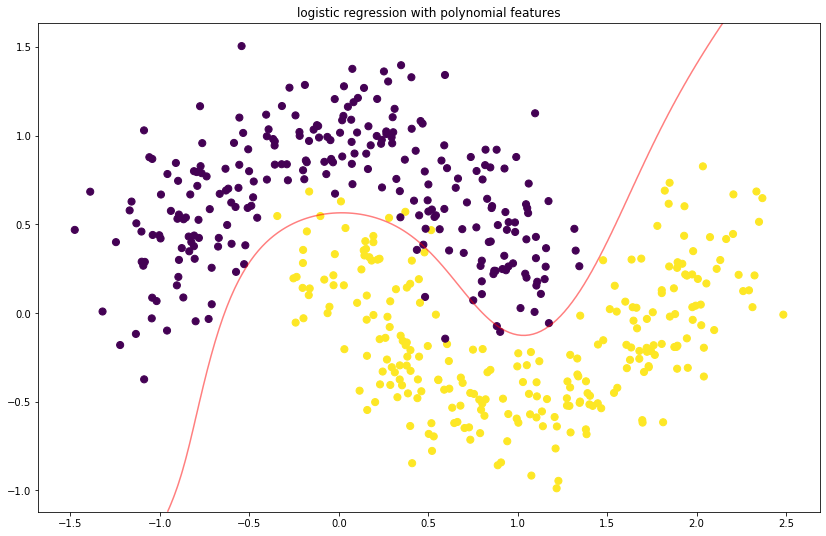

In [106]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score


plt.figure(figsize = (14, 9))
plt.title("logistic regression with polynomial features")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, s=50)


lr = LogisticRegression()
poly = PolynomialFeatures(degree = 7)
moon_points_transformed = poly.fit_transform(moons_points)
lr.fit(moon_points_transformed, moons_labels)
predict_labels = lr.predict(moon_points_transformed)

print("accuracy score =", accuracy_score(moons_labels, predict_labels))
plot_decision_surface_and_function(lr, moon_points_transformed, moons_labels, cmap='rainbow', color = 'r', 
                                   space = False, grid_step=0.01, poly_features = True, margin = False)

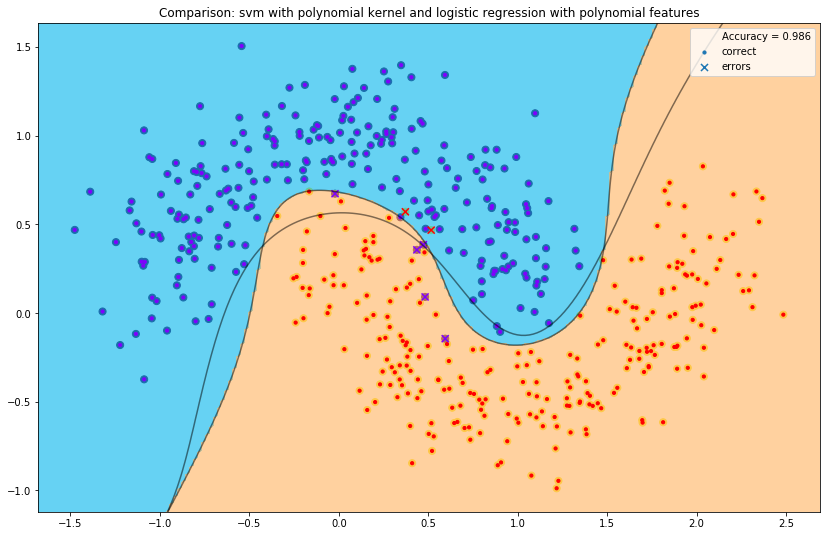

In [107]:
plt.figure(figsize = (14, 9))
plt.title("Comparison: svm with polynomial kernel and logistic regression with polynomial features")
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, s=50)
plot_decision_surface_and_function(lr, moon_points_transformed, moons_labels, cmap='rainbow', 
                                   space = False, grid_step=0.01, poly_features = True, margin = False)


svm = SVC(kernel='poly',
          degree = svm_grid_search.best_params_['degree'],
          coef0 = svm_grid_search.best_params_['coef0'])

svm.fit(moons_points, moons_labels)
plot_decision_surface_and_function(svm, moons_points, moons_labels, cmap='rainbow', grid_step=0.01, margin = False)  

Типы границ svm with poly kernel и logistic regression with polynomial features похожи. Точность классификации обеих методов близка друг к другу. Степень для полиномиальных фичей была выбрана равной 7, что является оптимальным значением в диапозоне от 2 до 15.  Оптимальный параметр для svm with poly kernel был равен 13. 

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

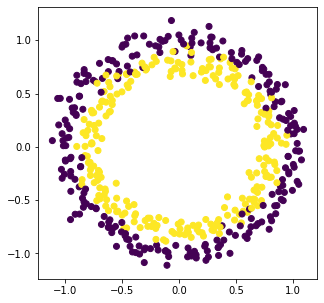

In [50]:
from sklearn.datasets import make_circles

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize = (5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels)

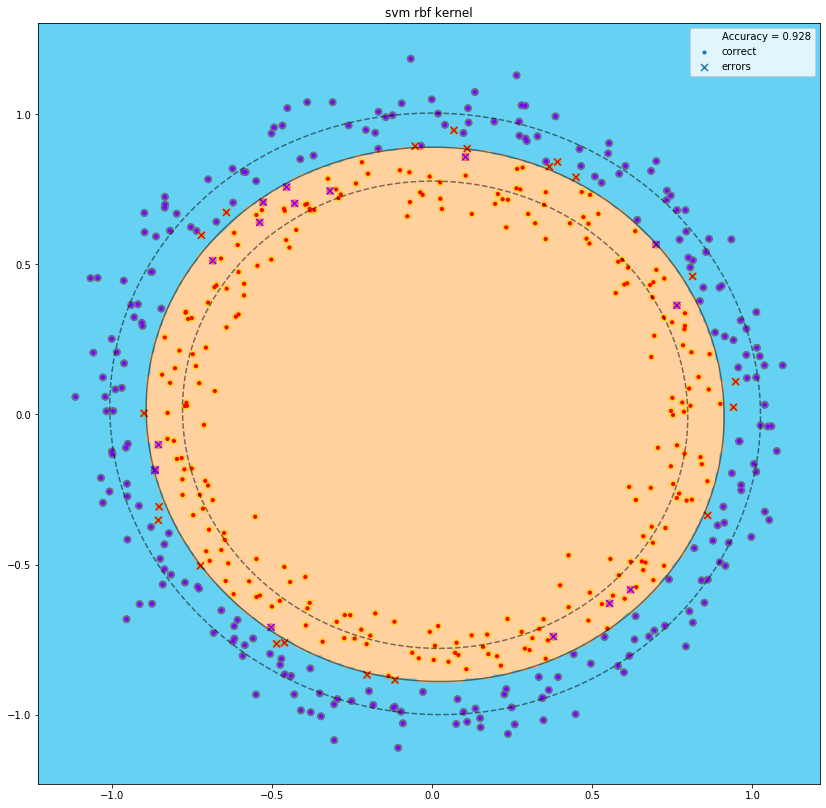

In [76]:
svm = SVC(kernel='rbf') 

svm.fit(circles_points, circles_labels)

plt.figure(figsize = (14, 14))
plt.title("svm with rbf kernel")
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels, s=50, cmap='autumn')
plot_decision_surface_and_function(svm, circles_points, circles_labels, cmap='rainbow', grid_step=0.01)  

And even more:

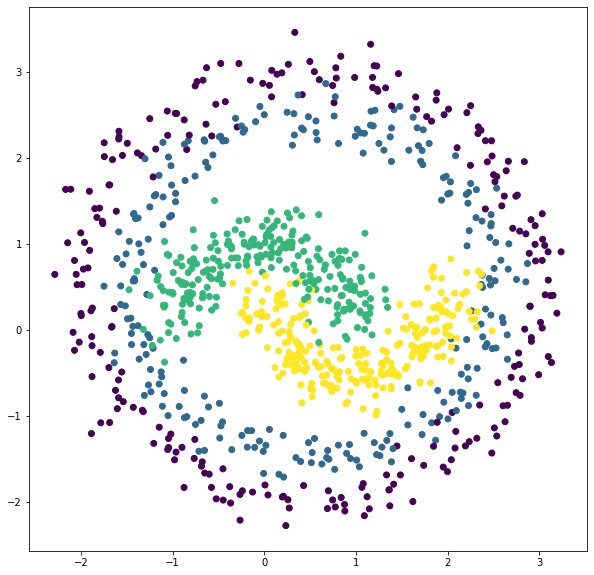

In [52]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes

plt.figure(figsize=(10, 10))
plt.scatter(points[:, 0], points[:, 1], c=labels)

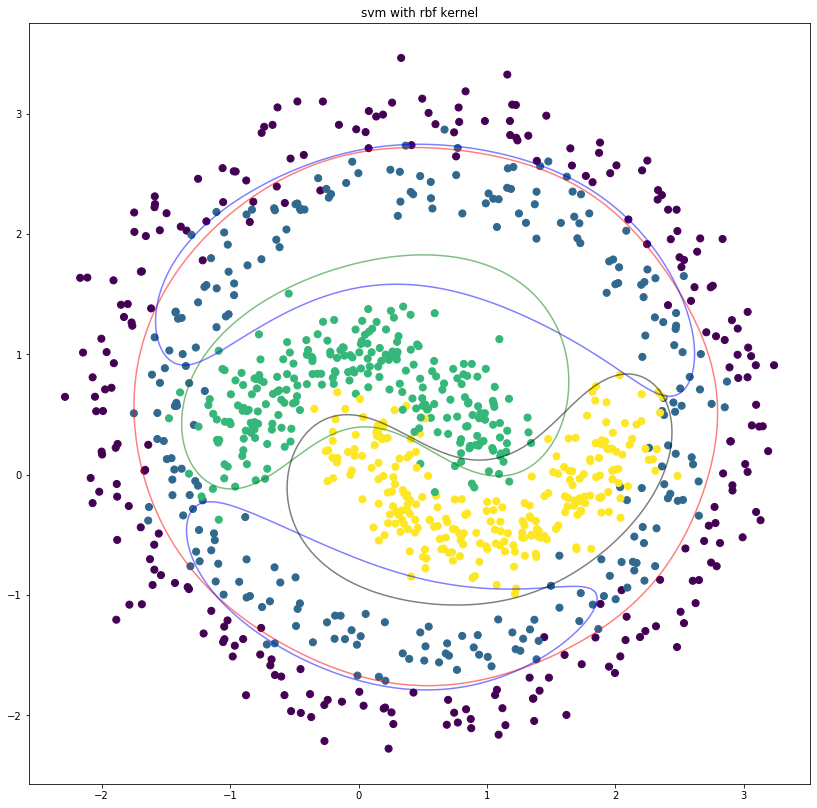

In [82]:
plt.figure(figsize = (14, 14))
plt.title("svm with rbf kernel")
plt.scatter(points[:, 0], points[:, 1], c=labels, s=50)
palette = list(['r', 'b', 'g', 'k'])
cmapps = list(['viridis', 'plasma', 'inferno', 'magma', 'cividis'])


svm = SVC(kernel='rbf', degree = 3) 
unique_labels = set(labels)


for i in unique_labels:

    new_labels = np.array(list(map(lambda x: i + int(x == i), labels)))
    svm.fit(points, new_labels)
    plot_decision_surface_and_function(svm, points, new_labels, color = palette[i],
                                       space = False, margin  = False, grid_step=0.01, alpha = 0.4)
    
   

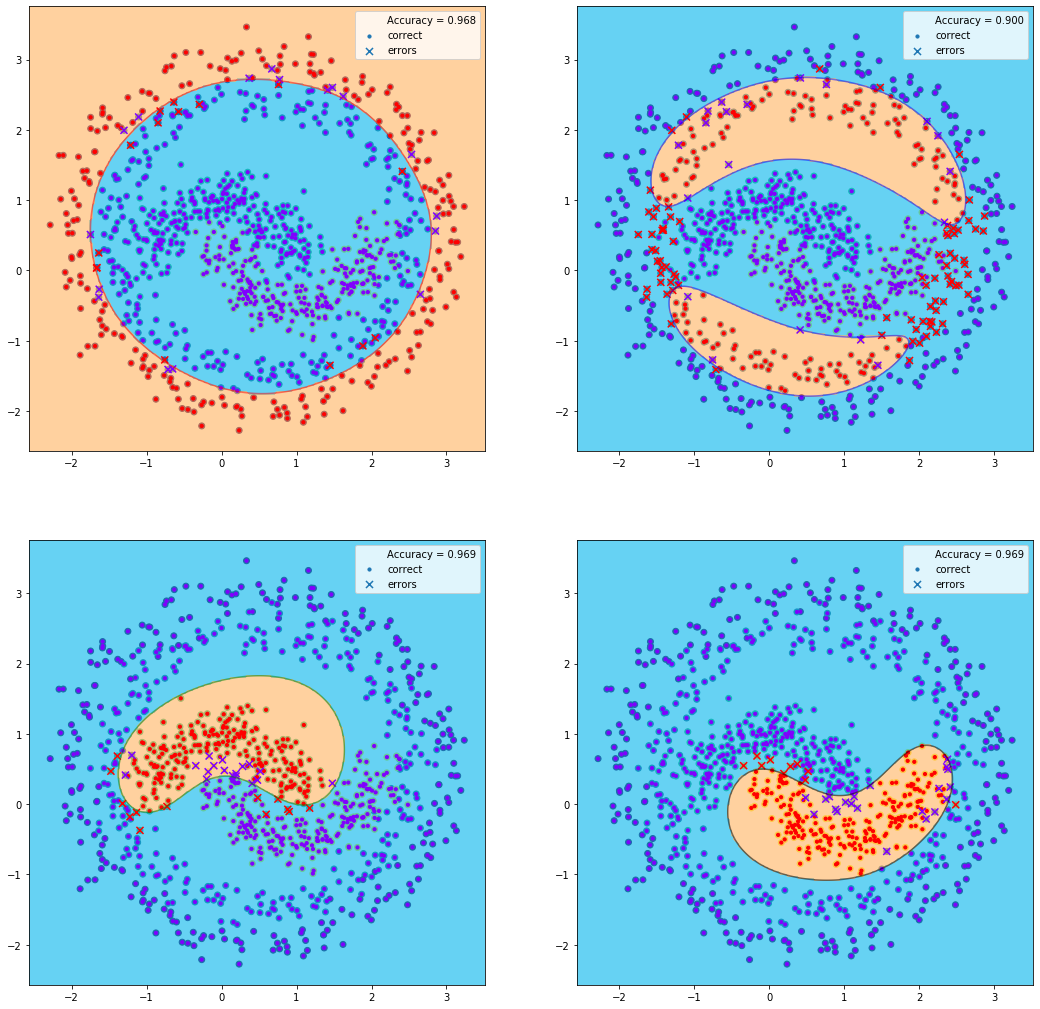

In [68]:
svm = SVC(kernel='rbf', degree = 3) 
unique_labels = set(labels)

plt.figure(figsize = (18, 18))
for i in range (0, 4):

    ax = plt.subplot(2, 2, i + 1)
    ax.scatter(points[:, 0], points[:, 1], c=labels)

    new_labels = np.array(list(map(lambda x: i + int(x == i), labels)))
    svm.fit(points, new_labels)
    plot_decision_surface_and_function(svm, points, new_labels, color = palette[i], ax = ax, 
                                       space = True, margin  = False, grid_step=0.01, cmap = 'rainbow')

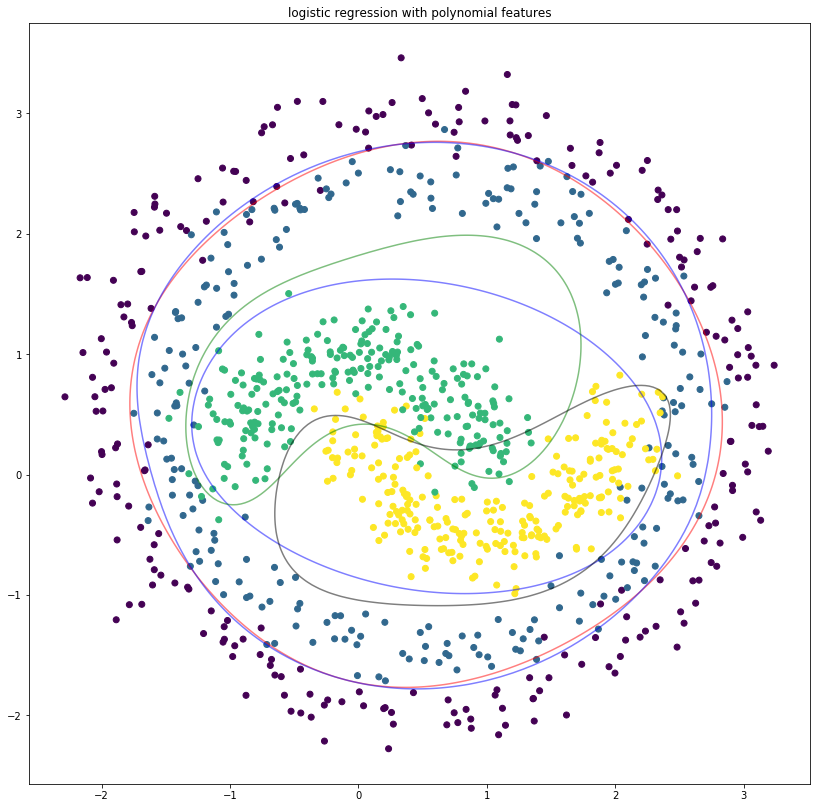

In [117]:
lr = LogisticRegression()
poly = PolynomialFeatures(degree = 4)
points_transformed = poly.fit_transform(points)


plt.figure(figsize = (14, 14))
plt.title("logistic regression with polynomial features")
plt.scatter(points[:, 0], points[:, 1], c=labels)
palette = list(['r', 'b', 'g', 'k'])
cmapps = list(['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

unique_labels = set(labels)

for i in unique_labels:
    new_labels = np.array(list(map(lambda x: i + int(x == i), labels)))
    lr.fit(points_transformed, new_labels)
    plot_decision_surface_and_function(lr, points_transformed, new_labels, color = palette[i], 
                                       poly_features = True,
                                       space = False, margin  = False, grid_step=0.01)

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

В данной задаче логистическая регрессия с полиномиальными фичами даёт результат, схожий с результатом svm с радиальным ядром (rbf). Радиальное ядро является оптимальным выбором в данной задачи - такой вывод можно сделать основываясь на графическом представлении данных (круги) и непосредственной проверке. 